# Searching and Downloading GEDI L4A Dataset

Updates: Xihan Yao, 2024/04/15
Xihan Yao is testing the programming skills and explore the GEDI data.

This tutorial will demonstrate how to search and download [Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD)](https://doi.org/10.3334/ORNLDAAC/2056) dataset. GEDI L4A dataset is available for the period starting 2019-04-17 and covers latitudes of 52 North to 52 South. GEDI L4A data files are natively in HDF5 format, and each file represents one International Space Station (ISS) orbit. 

We will use NASA's Earthdata [Common Metadata Repository (CMR) Application Programming Interface (API)](https://cmr.earthdata.nasa.gov/search) to search for GEDI L4A files or granules for time and area of interest. CMR catalogs metadata records of NASA Earth Science data and make them available for easy programmatic access. Area of interest can be defined using a bounding box (Option 1) or using polygons (Option 2).

This tutorial requires the following Python modules installed in your system: `requests`, `datetime`, `pandas`, `geopandas`, `shapely`. Requirements are also in [requirements.txt](requirements.txt). To install the necessary Python modules, you can copy the requirements.txt from this repository and run:
```bash
pip install -r requirements.txt
```

In [113]:
%matplotlib inline
import requests
import datetime as dt 
import pandas as pd
import geopandas as gpd
import contextily as ctx 
from shapely.geometry import MultiPolygon, Polygon, box
from shapely.ops import orient

## 1. Searching with a bounding box (Option 1)

NASA EarthData's unique ID for this dataset (called `Concept ID`) is needed for searching the dataset. The dataset Digital Object Identifier or DOI can be used to obtain the `Concept ID`.

In [114]:
# This is a tutorial on the GEDI mission dataset. Testing GitHub. 
# This comment was added din 240415

doi = '10.3334/ORNLDAAC/2056'# GEDI L4A DOI 

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi
response = requests.get(doisearch)
response.raise_for_status()
concept_id = response.json()['feed']['entry'][0]['id']

print(concept_id)

C2237824918-ORNL_CLOUD


This is the unique NASA-given concept ID for the GEDI 4A dataset, which can be used to retrieve relevant files (or granules) for GEDI L4A. 

Compared to the original bounding box, Xihan Yao changed the bounding box to be an area in the Big Basin Redwoods State Park

In [115]:
# Brazil bounding box
boundBrazil = (-73.9872354804, -33.7683777809, -34.7299934555, 5.24448639569) 

#Redwood bounding box
boundRedwood = ( -122.40, 37.35, -122.35, 37.40) 

# time bound
start_date = dt.datetime(2021, 7, 1) # specify your own start date
end_date = dt.datetime(2021, 7, 31)  # specify your end start date

The bounding box and time-bound can be used to search for GEDI L4A files using the CMR API. The CMR API only allows searching 2000 files at a time. Using `page_num` parameter allows to loop through the search result pages. We will use [pandas dataframe](https://pandas.pydata.org/) to store the download URLs of each file and their bounding geometries.

In [116]:
# CMR formatted start and end times
dt_format = '%Y-%m-%dT%H:%M:%SZ'
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

# CMR formatted bounding box
bound_str = ','.join(map(str, boundRedwood))

page_num = 1
page_size = 2000 # CMR page size limit

granule_arr = []

while True:
    
    # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": temporal_str,
        "bounding_box[]": bound_str
    }
    
    granulesearch = cmrurl + 'granules.json'

    response = requests.get(granulesearch, params=cmr_param)
    response.raise_for_status()
    granules = response.json()['feed']['entry']
    
    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''
            
            # read file size
            granule_size = float(g['granule_size'])
            
            # reading bounding geometries
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i=iter(poly[0].split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)
            
            # Get URL to HDF5 files
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') \
                and links['title'].endswith('.h5'):
                    granule_url = links['href']
            granule_arr.append([granule_url, granule_size, granule_poly])
               
        page_num += 1
    else: 
        break

# adding bound as the last row into the dataframe
# we will use this later in the plot
b = list(boundRedwood)
granule_arr.append(['bound', 0, box(b[0], b[1], b[2], b[3])]) 

# creating a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

# Drop granules with empty geometry
l4adf = l4adf[l4adf['granule_poly'] != '']

print ("Total granules found: ", len(l4adf.index)-1)
print ("Total file size (MB): ", l4adf['granule_size'].sum())

Total granules found:  1
Total file size (MB):  238.15311


Now, we have stored the granule URLs and their bounding geometries into the pandas dataframe `l4adf`. The first few rows of the table look like the following.

In [117]:
l4adf.head()

,granule_url,granule_size,granule_poly
0,https://data.ornldaac.earthdata.nasa.gov/prote...,238.15311,"MULTIPOLYGON (((-139.2264709 22.1020317, -136...."
1,bound,0.00000,"POLYGON ((-122.35 37.35, -122.35 37.4, -122.4 ..."


We can now plot the bounding geometries of the granules (shown with green lines in the figure below) using [geopandas](https://geopandas.org/). The bounding box (of Brazil) is plotted in red color.

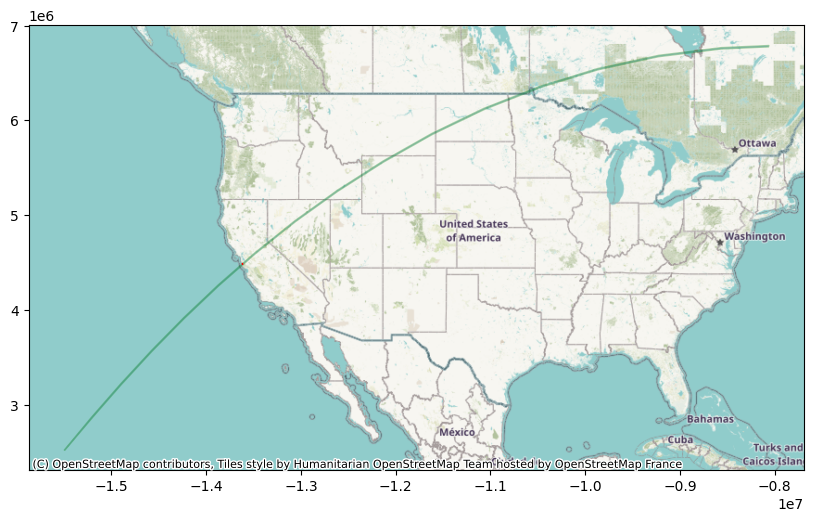

In [118]:
# creating a geopandas dataframe
gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
# assiging CRS as WGS84
gdf.crs = "EPSG:4326"
# converting CRS to Web Mercator, the reference system of the contextily basemap
gdf_epsg3857 = gdf.to_crs(epsg=3857)
# plotting GEDI suborbits
ax=gdf_epsg3857[:-1].plot(figsize=(10, 6), alpha=0.3, edgecolor='green')
# plotting the bounding box (last row)
gdf_epsg3857[-1:].plot(ax=ax, facecolor='none', edgecolor='red')
# adding to contextily basemap
ctx.add_basemap(ax)

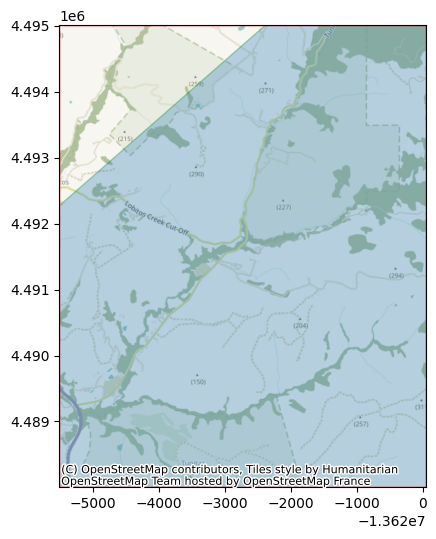

In [119]:
# Assuming l4adf is already defined and contains the necessary data
gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
gdf.crs = "EPSG:4326"
gdf_epsg3857 = gdf.to_crs(epsg=3857)

# Plotting GEDI suborbits
ax = gdf_epsg3857[:-1].plot(figsize=(10, 6), alpha=0.3, edgecolor='green')

# Plotting the bounding box (last row)
gdf_epsg3857[-1:].plot(ax=ax, facecolor='none', edgecolor='red')

# Optionally, you can set the extent of the plot to the bounds of the bounding box
# This will zoom into the area covered by the bounding box
bounds = gdf_epsg3857[-1:].total_bounds
ax.set_xlim([bounds[0], bounds[2]])
ax.set_ylim([bounds[1], bounds[3]])

# Adding a basemap
ctx.add_basemap(ax, crs=gdf_epsg3857.crs.to_string())


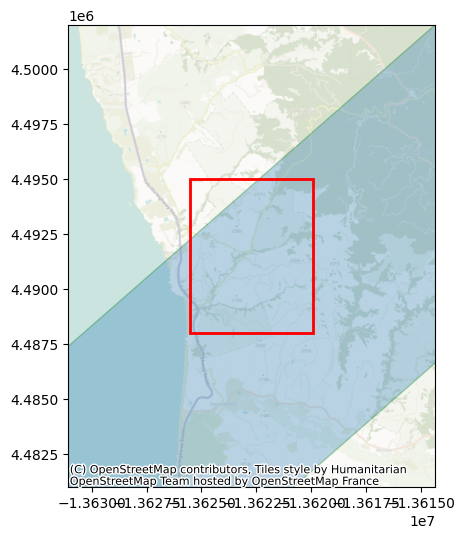

In [121]:
def plot_gedi_suborbits(l4adf):
    # Convert the DataFrame to a GeoDataFrame with the specified CRS
    gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf['granule_poly'])
    gdf.crs = "EPSG:4326"
    gdf_epsg3857 = gdf.to_crs(epsg=3857)

    # Plotting GEDI suborbits
    ax = gdf_epsg3857[:-1].plot(figsize=(10, 6), alpha=0.3, edgecolor='green')

    # Plotting the bounding box (last row)
    bbox = gdf_epsg3857[-1:]
    bbox.plot(ax=ax, facecolor='none', edgecolor='red')

    # Get the bounds of the bounding box and adjust them
    bounds = bbox.total_bounds
    x_range = abs(bounds[2] - bounds[0])
    y_range = abs(bounds[3] - bounds[1])

    # Expand the bounds to show more area around the bounding box
    # Expanded bounds calculation to cover roughly 60% of the plot's area
    expanded_bounds = [
        bounds[0] - x_range,  # Min x
        bounds[1] - y_range,  # Min y
        bounds[2] + x_range,  # Max x
        bounds[3] + y_range,  # Max y
    ]

    # Set the expanded bounds as the limits for the plot
    ax.set_xlim([expanded_bounds[0], expanded_bounds[2]])
    ax.set_ylim([expanded_bounds[1], expanded_bounds[3]])

    # Add a red box around the original bounding box to highlight it
    rect = Rectangle((bounds[0], bounds[1]), x_range, y_range, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # Adding a basemap, reprojecting it to match the data's projection
    ctx.add_basemap(ax, crs=gdf_epsg3857.crs.to_string(), alpha=0.5)

    # Show the plot
    plt.show()

# Example usage:
# Assuming l4adf is already defined and contains the necessary data
# plot_gedi_suborbits(l4adf)

plot_gedi_suborbits(l4adf)

### 1.8. Download the study scope from an external source 

In [122]:
import requests
import json
# Your NPS API key
api_key = 'bzvRKg5Tdfcn0ygO8CkPjnD6FoVHZxPcc6j7d5F8'

# URL for the NPS API endpoint
url = 'https://developer.nps.gov/api/v1/parks'

# Parameters for the API request
params = {
    'api_key': api_key,
    'fields': 'latLong',  # Adjust fields as necessary, e.g., include 'boundary' if available
    'limit': '10'  # Adjust the limit as needed
}

# Make the API request
response = requests.get(url, params=params)

# # Check if the request was successful
# if response.status_code == 200:
#     # Parse the JSON response
#     data = response.json()

#     # Print the data
#     print(json.dumps(data, indent=2))
# else:
#     print("Failed to retrieve data:", response.status_code)

# Note: Handle pagination if more than 10 parks are needed

C:\Users\Yao Xihan\AppData\Local\Temp\ipykernel_24708\3624592600.py:38: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


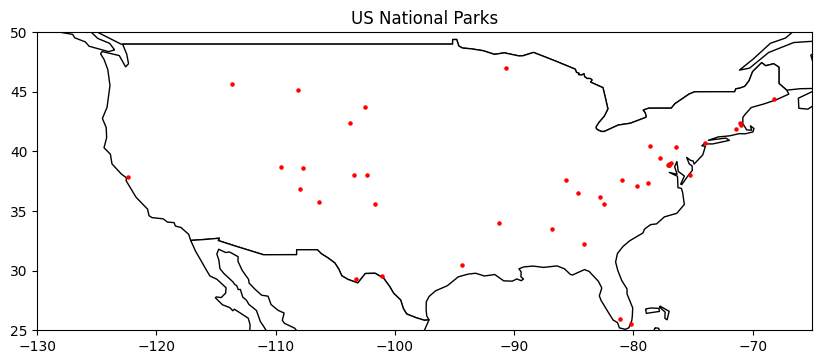

In [49]:
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Parameters for the API request
params = {
    'api_key': api_key,
    'fields': 'latLong',
    'limit': '50'  # Increase or decrease based on your needs
}

# Make the API request
response = requests.get(url, params=params)

# Initialize an empty list to collect GeoDataFrame rows
rows = []

# Check if the request was successful
if response.status_code == 200:
    parks = response.json()['data']
    # Loop through the data and create rows to add to the GeoDataFrame
    for park in parks:
        latlong = park['latLong']
        if latlong:
            try:
                lat, lng = map(float, latlong.strip('latLong:').replace('lat:', '').replace('long:', '').split(','))
                point = Point(lng, lat)
                rows.append({'name': park['fullName'], 'geometry': point})
            except ValueError:
                continue  # Skip any parks without proper lat-long information
else:
    print("Failed to retrieve data:", response.status_code)

# Create a GeoDataFrame from the list of rows
gdf = gpd.GeoDataFrame(rows, columns=['name', 'geometry'])

# Plot using GeoPandas
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='white', edgecolor='black')
# Set bounds to focus on the continental USA
ax.set_xlim([-130, -65])
ax.set_ylim([25, 50])
gdf.plot(ax=ax, marker='o', color='red', markersize=5)
plt.title('US National Parks')
plt.show()

### 1.9 Get the boundary for Lassen Vocanic National Park

In [123]:
import fiona
import os

# URL pointing to the GeoDatabase file
gdb_url = "/vsicurl/https://huggingface.co/datasets/cboettig/biodiversity/resolve/main/data/NPS.gdb"

# List all layers in the GDB file
layers = fiona.listlayers(gdb_url)
print("Layers available in GeoDatabase:", layers)


if layers:
    gdf = gpd.read_file(gdb_url, layer=layers[0])  # Adjust 'layers[0]' as necessary
    # print(gdf.head())  # Display the first few rows to confirm loading

    # Filtering for Lassen Volcanic National Park
    lassen_gdf = gdf[gdf['UNIT_NAME'] == 'Lassen Volcanic National Park']
    print("Filtered record for Lassen Volcanic National Park:")
    print(lassen_gdf)
else:
    print("No layers found in the specified GeoDatabase.")

Layers available in GeoDatabase: ['nps_boundary']
Filtered record for Lassen Volcanic National Park:
                 CreationDate         Creator                  EditDate  \
322 2023-10-13 12:14:29+00:00  NPS_WASO_LANDS 2023-10-13 12:14:29+00:00   

             Editor                                GlobalID  AreaID UNIT_CODE  \
322  NPS_WASO_LANDS  {E51D7EA6-CBE2-415A-A3D5-96556CDCE053}   345.0      LAVO   

                                             GIS_Notes  \
322  Lands - http://landsnet.nps.gov/tractsnet/docu...   

                         UNIT_NAME                 DATE_EDIT STATE REGION  \
322  Lassen Volcanic National Park 2015-08-19 00:00:00+00:00    CA     PW   

    GNIS_ID      UNIT_TYPE CREATED_BY  \
322  262325  National Park      Lands   

                                              METADATA         PARKNAME  \
322  https://irma.nps.gov/DataStore/Reference/Profi...  Lassen Volcanic   

      SHAPE_Length    SHAPE_Area  \
322  149637.527913  7.530977e+08   

      

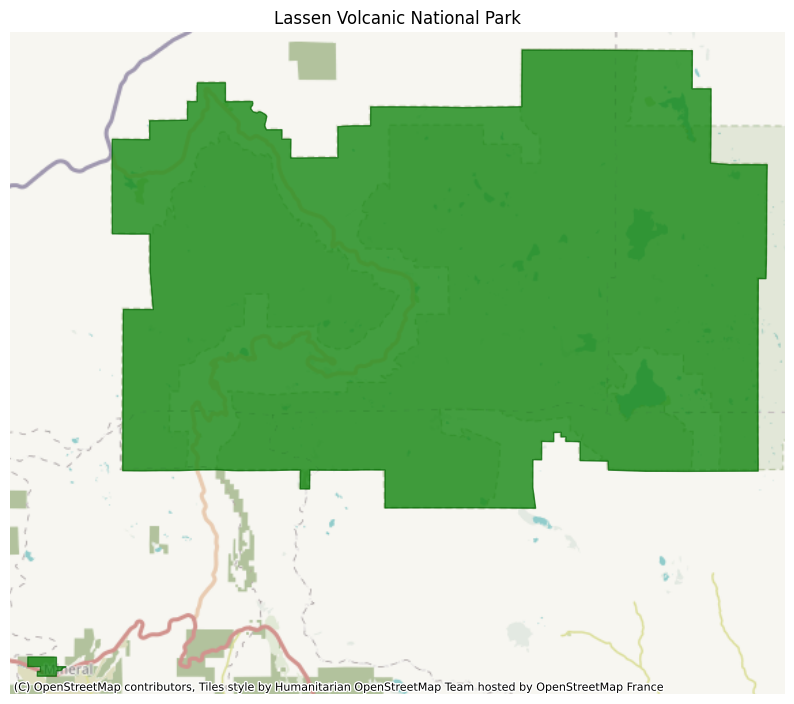

In [124]:
# Plot setup
fig, ax = plt.subplots(figsize=(10, 10))  # Create a plot figure and an axes subplot

# Plotting the Lassen Volcanic National Park with data projected to Web Mercator (for contextily compatibility)
# First, ensure your data is in EPSG:4326, then convert to EPSG:3857 for the basemap
lassen_gdf = lassen_gdf.to_crs(epsg=3857)  # Converts GeoDataFrame to the Mercator projection used by most web maps

# Plotting the Lassen Volcanic National Park
lassen_gdf.plot(ax=ax, color='green', edgecolor='darkgreen', alpha=0.7)  # Set alpha for better map visibility

# Adding a basemap
ctx.add_basemap(ax, crs=lassen_gdf.crs.to_string())

# Adjust bounds
minx, miny, maxx, maxy = lassen_gdf.total_bounds
# Expand the bounds a bit more for context
ax.set_xlim(minx - 1000, maxx + 1000)
ax.set_ylim(miny - 1000, maxy + 1000)

# Enhancements for better visualization
ax.set_title('Lassen Volcanic National Park')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('off')  # Optionally turn off the axis if the basemap provides enough context

plt.grid(True)
plt.show()

In [125]:
import folium

# Drop fields that are not necessary for the map or causing serialization issues
fields_to_drop = ['CreationDate', 'EditDate', 'DATE_EDIT', 'METADATA']
lassen_gdf_d = lassen_gdf.drop(columns=fields_to_drop)

# Ensure the data is in the correct CRS for Folium (EPSG:4326)
lassen_gdf_d = lassen_gdf_d.to_crs(epsg=4326)

# Create a folium map centered on the centroid of the national park
center = lassen_gdf_d.geometry.centroid.iloc[0]
lat, lon = center.y, center.x
m = folium.Map(location=[lat, lon], zoom_start=10, tiles='OpenStreetMap')

# Add the park boundary to the map using GeoJson
folium.GeoJson(
    lassen_gdf_d,
    name='Lassen Volcanic National Park',
    style_function=lambda feature: {
        'fillColor': 'green',
        'color': 'green',
        'weight': 2,
        'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(fields=['UNIT_NAME', 'PARKNAME', 'STATE'], aliases=['Park Name:', 'Park Name:', 'State:'])
).add_to(m)

# Display the map
m.save('lassen_volcanic_national_park_map.html')
m  # If using Jupyter Notebook, this will display the map inline

C:\Users\Yao Xihan\AppData\Local\Temp\ipykernel_24708\674519192.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = lassen_gdf_d.geometry.centroid.iloc[0]


In [101]:
# Define the path to the folder and the file name
output_folder = "polygons"
output_filename = "lassen_volcanic_national_park.geojson"

# Ensure the output folder exists, create if it does not
import os
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Full path for the output file
output_path = os.path.join(output_folder, output_filename)

# Save the GeoDataFrame as GeoJSON
lassen_gdf_d.to_file(output_path, driver='GeoJSON')

print(f"Saved GeoJSON file at: {output_path}")

Saved GeoJSON file at: polygons\lassen_volcanic_national_park.geojson


## 2. Searching for a polygonal area of interest (Option 2)

If an area of interest is already defined as a polygon, the polygon file (`geojson`, `shapefile` or `kml`) can be used to find overlapping GEDI L4A files. More details about this capability are described in [this page](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#c-shapefile).

From now on, Xihan will experiment the use of Lassen Vocanic National Park using the GEDI data. 

<!-- For this tutorial, we will use the boundary of a northern states of Brazil, Amapá to search for the overlapping GEDI files. The boundary polygon is stored in a geojson file called `amapa.json` (shown in red polygon in the figure below). -->

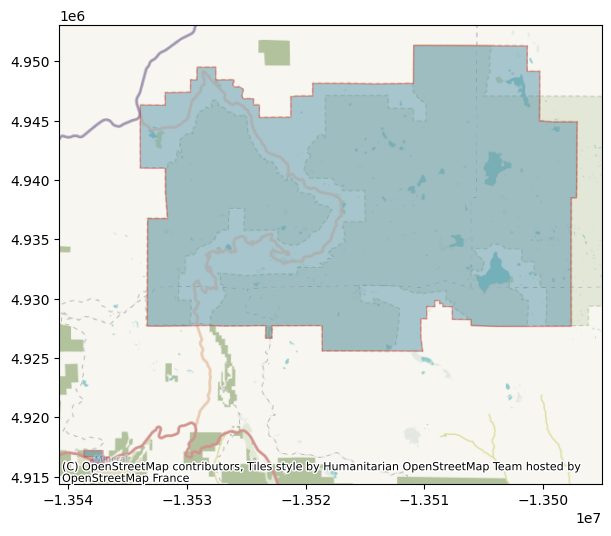

In [126]:
# amapa = gpd.read_file("polygons/amapa.json") 
# amapa.geometry = amapa.geometry.apply(orient, args=(1,))
# ax = amapa.to_crs(epsg=3857).plot(figsize=(7, 7), alpha=0.3, edgecolor='red')
# ctx.add_basemap(ax)

lassen_volcanic_national_park = gpd.read_file("polygons/lassen_volcanic_national_park.geojson") 
lassen_volcanic_national_park.geometry = lassen_volcanic_national_park.geometry.apply(orient, args=(1,))
ax = lassen_volcanic_national_park.to_crs(epsg=3857).plot(figsize=(7, 7), alpha=0.3, edgecolor='red')
ctx.add_basemap(ax)

# lassen_gdf_d.geometry= lassen_gdf_d.geometry.apply(orient, args=(1,))

# ax = lassen_gdf_d.to_crs(epsg=3857).plot(figsize=(7, 7), alpha=0.3, edgecolor='red')
# ctx.add_basemap(ax)

In this example, we will search for all the GEDI L4A files available for the area using the CMR API.

In [127]:
doi = '10.3334/ORNLDAAC/2056'# GEDI L4A DOI 

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi
response = requests.get(doisearch)
response.raise_for_status()
concept_id = response.json()['feed']['entry'][0]['id']

geojson = {"shapefile": ("lassen_volcanic_national_park.geojson", lassen_volcanic_national_park.geometry.to_json(), "application/geo+json")}

page_num = 1
page_size = 2000 # CMR page size limit

granule_arr = []

while True:
    
     # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id, 
        "page_size": page_size,
        "page_num": page_num,
        "simplify-shapefile": 'true' # this is needed to bypass 5000 coordinates limit of CMR
    }
    
    granulesearch = cmrurl + 'granules.json'
    response = requests.post(granulesearch, data=cmr_param, files=geojson)
    granules = response.json()['feed']['entry']
       
    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''
                       
            # read file size
            granule_size = float(g['granule_size'])
    
            # reading bounding geometries
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i=iter(poly[0].split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)
            
            # Get URL to HDF5 files
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') \
                and links['title'].endswith('.h5'):
                    granule_url = links['href']
            granule_arr.append([granule_url, granule_size, granule_poly])
               
        page_num += 1
    else: 
        break



# adding bound as the last row into the dataframe
# we will use this later in the plot
granule_arr.append(['lassen_volcanic_national_park', 0, lassen_volcanic_national_park.geometry.item() ]) 

# creating a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

# Drop granules with empty geometry
l4adf = l4adf[l4adf['granule_poly'] != '']

print ("Total granules found: ", len(l4adf.index)-1 )
print ("Total file size (MB): ", l4adf['granule_size'].sum())

Total granules found:  80
Total file size (MB):  20871.189538


Now, we have stored the granule URLs and their bounding geometries into the pandas dataframe `l4adf`. The first few rows of the table look like the following.

In [128]:
l4adf.head()

,granule_url,granule_size,granule_poly
0,https://data.ornldaac.earthdata.nasa.gov/prote...,225.556878,"MULTIPOLYGON (((-141.1750488 24.1161346, -138...."
1,https://data.ornldaac.earthdata.nasa.gov/prote...,288.814876,"MULTIPOLYGON (((-152.4307251 50.8254128, -146...."
2,https://data.ornldaac.earthdata.nasa.gov/prote...,205.115378,"MULTIPOLYGON (((-141.2059784 24.2874737, -138...."
3,https://data.ornldaac.earthdata.nasa.gov/prote...,280.788434,"MULTIPOLYGON (((-152.1964874 50.7310371, -146...."
4,https://data.ornldaac.earthdata.nasa.gov/prote...,218.401454,"MULTIPOLYGON (((-141.3251038 24.3699303, -138...."


We can now plot the bounding geometries of the granules (shown with green lines in the figure below) using geopandas. The Amapá state is plotted in red color.

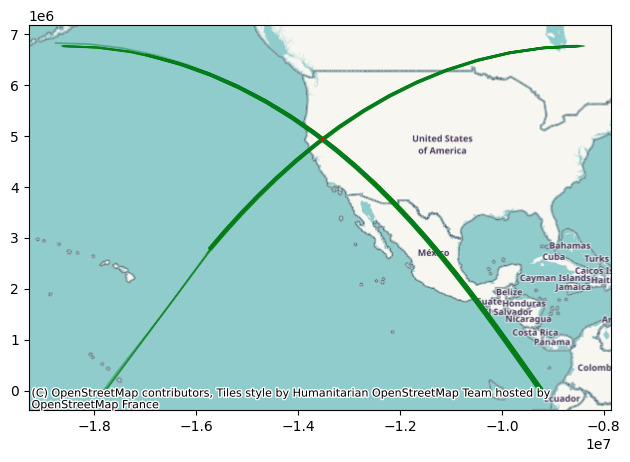

In [129]:
# creating a geopandas dataframe
gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
# assiging CRS as WGS84
gdf.crs = "EPSG:4326"
# converting CRS to Web Mercator, the reference system of the contextily basemap
gdf_epsg3857 = gdf.to_crs(epsg=3857)
# plotting GEDI suborbits bounding geometry
ax=gdf_epsg3857[:-1].plot(figsize=(10, 5), alpha=0.3, edgecolor='green')
# plotting the bounding box (last row)
gdf_epsg3857[-1:].plot(ax=ax, facecolor='none', edgecolor='red')
# adding to contextily basemap
ctx.add_basemap(ax)

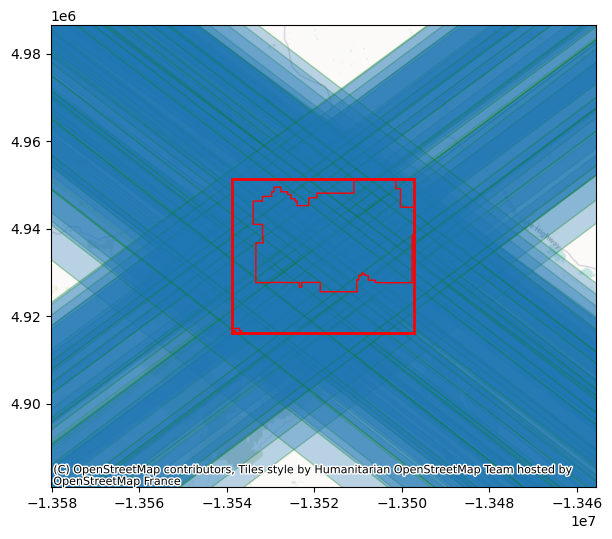

In [130]:
plot_gedi_suborbits(l4adf)

## 3. Downloading the files

We recommend using utilities such as `cURL` or `wget` to download the files. You will first need to set up NASA Earthdata Login authentication using `.netrc` file. Please refer to this page for details on setting up such authentication: https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget.

Once the authentication has been setup (Steps 1-3 on the above page), the GEDI L4a files can be downloaded as follows.

First, save the granule URLs to a file `granules.txt`. 

In [ ]:
# drop duplicate URLs if any
l4a_granules = l4adf[:-1].drop_duplicates(subset=['granule_url'])
l4a_granules.to_csv('granules.txt', columns = ['granule_url'], index=False, header = False)

Either of the following commands can then be issued from the terminal to download the files.

#### wget
```
wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --auth-no-challenge=on --keep-session-cookies --content-disposition -nc -i granules.txt
```
#### curl
```
cat granules.txt | tr -d '\r' | xargs -n 1 curl -LJO -n -c ~/.urs_cookies -b ~/.urs_cookies
```